In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# basic imports
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import load_model, Sequential
from keras.layers import Input, GRU, BatchNormalization, Dropout, Dense
from keras.optimizers import Adam
from keras.losses import Huber
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, LeakyReLU, Dense, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.optimizers import AdamW, Nadam
from tensorflow.keras.losses import MeanSquaredError
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer, PowerTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from IPython.display import Audio, display

In [4]:
# load the z normalized csv file and print the first 5 elements
df_z = pd.read_csv('/content/drive/MyDrive/KobolRSF/z_norm_normalized.csv')
print(df_z.head(5))

   waveform  frequency  loudness  angular_frequency  cv_frequency  \
0 -1.095445  -0.570372  0.583288          -0.570372     -0.603023   
1 -0.912871  -0.614286  0.116979          -0.614286     -1.658312   
2 -0.912871  -0.121019  0.839874          -0.121019      0.452267   
3  0.365148   0.369809  1.073398           0.369809      0.753778   
4  0.365148  -0.574788  1.005427          -0.574788     -1.356801   

   cv_waveform                                      waveform_data  
0    -1.095445  [0.004897026111065445, 0.007693380216497472, 0...  
1    -0.912871  [0.003883592364903525, 0.00569756987286506, 0....  
2    -0.912871  [0.004425870452870818, 0.006301556181129648, 0...  
3     0.365148  [0.0034790566683923566, 0.0054943118451357235,...  
4     0.365148  [-0.00030412342008344085, 0.000963275270793247...  


In [6]:
# load the min max normalized csv file and print the first 5 elements
df_minmax = pd.read_csv('/content/drive/MyDrive/KobolRSF/min_max_normalized.csv')
print(df_minmax.head(5))

   waveform  frequency  loudness  angular_frequency  cv_frequency  \
0  0.166667   0.007308  0.679394           0.007308      0.318182   
1  0.222222   0.000000  0.552535           0.000000      0.000000   
2  0.222222   0.090855  0.749198           0.090855      0.636364   
3  0.611111   0.181927  0.812728           0.181927      0.727273   
4  0.611111   0.000436  0.794237           0.000436      0.090909   

   cv_waveform                                      waveform_data  
0     0.166667  [0.4125868332168019, 0.4134146234850297, 0.413...  
1     0.222222  [0.7413616504920845, 0.7418579713822683, 0.741...  
2     0.222222  [0.4326447534699928, 0.4332005402044114, 0.432...  
3     0.611111  [0.5069494969255856, 0.5077130302054113, 0.507...  
4     0.611111  [0.5090390990177646, 0.5093467932029825, 0.509...  


In [9]:
# load the PU model
model = load_model('/content/drive/MyDrive/KobolRSF/code/PU.h5')

In [10]:
# from PU
class PhaseIntegrator:
    def __init__(self, cv: float, start_time: float = 0, end_time: float = 200, num_steps: int = 1000):
        """
        Initializes the PhaseIntegrator with the given cv value and time range.

        Args:
            cv (float): The cv value to use for the prediction.
            start_time (float, optional): Start time for the integration. Defaults to 0.
            end_time (float, optional): End time for the integration. Defaults to 200.
            num_steps (int, optional): Number of steps for integration. Defaults to 1000.
        """
        self.cv = cv
        self.start_time = start_time
        self.end_time = end_time
        self.num_steps = num_steps
        self.prediction = self.make_prediction([cv])
        self.time_steps = np.linspace(start_time, end_time, self.num_steps)
        self.first_prediction = self.prediction[0]
        self.integrated_phases = np.zeros_like(self.time_steps)
        self.folded_phases = None

    def make_prediction(self, input_value):
        """
        Makes a prediction based on the input value using the model.

        Args:
            input_value (list): The input value for the prediction.

        Returns:
            np.ndarray: The predicted values.
        """
        input_value = np.array(input_value).reshape(1, -1)
        prediction = model.predict(input_value)
        return prediction

    def calculate_first_prediction(self) -> float:
        """
        Calculates the first prediction's integration result.

        Returns:
            float: The result of the integration for the first prediction.
        """
        second_time_step = self.time_steps[1]
        predicted_value = self.first_prediction
        result = second_time_step * predicted_value
        print(f'First Predicted Value: {predicted_value}')
        print(f'Result of integration: {result}')
        return result

    def integrate_phases(self) -> None:
        """
        Integrates the phases over the time steps using the first prediction.
        """
        for i, time_step in enumerate(self.time_steps):
            self.integrated_phases[i] = time_step * self.first_prediction

    def fold_phases(self) -> None:
        """
        Folds the integrated phases to be within the range [0, 1).
        """
        self.folded_phases = self.integrated_phases % 1.0

    def plot_phases(self) -> None:
        """
        Plots the folded phases against the time steps.

        Raises:
            ValueError: If folded phases have not been calculated yet.
        """
        if self.folded_phases is None:
            raise ValueError("Folded phases have not been calculated yet. Call fold_phases() first.")
        plt.figure(figsize=(10, 6))
        plt.plot(self.time_steps, self.folded_phases, label='Integrated Phases')
        plt.xlabel('Time Steps')
        plt.ylabel('Integrated Phases')
        plt.title('Integrated Phases vs Time Steps')
        plt.grid(True)
        plt.legend()
        plt.show()

    def run(self) -> None:
        """
        Runs the full phase integration process including calculation, integration,
        folding, and plotting of phases.
        """
        self.calculate_first_prediction()
        self.integrate_phases()
        self.fold_phases()
        # self.plot_phases() #only activate when plotting the phases is needed
        return self.folded_phases

In [12]:
df_z['waveform_data'] = df_z['waveform_data'].apply(lambda x: x.replace('[', '').replace(']', '').strip())
df_z['waveform_data'] = df_z['waveform_data'].apply(lambda x: np.array(list(map(float, x.split(',')))))
df_z.head()

,waveform,frequency,loudness,angular_frequency,cv_frequency,cv_waveform,waveform_data
0,-1.095445,-0.570372,0.583288,-0.570372,-0.603023,-1.095445,"[0.004897026111065445, 0.007693380216497472, 0..."
1,-0.912871,-0.614286,0.116979,-0.614286,-1.658312,-0.912871,"[0.003883592364903525, 0.00569756987286506, 0...."
2,-0.912871,-0.121019,0.839874,-0.121019,0.452267,-0.912871,"[0.004425870452870818, 0.006301556181129648, 0..."
3,0.365148,0.369809,1.073398,0.369809,0.753778,0.365148,"[0.0034790566683923566, 0.0054943118451357235,..."
4,0.365148,-0.574788,1.005427,-0.574788,-1.356801,0.365148,"[-0.00030412342008344085, 0.000963275270793247..."


## Data preparation for the Z Norm dataset

In [14]:
X = df_z[['cv_frequency', 'cv_waveform', 'waveform', 'frequency']]
y = np.array(df_z['waveform_data'].tolist())
folded_phases_list = []
for cv in X['cv_frequency']:
    integrator = PhaseIntegrator(cv)
    folded_phases = integrator.run()
    folded_phases_list.append(folded_phases[-1])

X['folded_phases'] = folded_phases_list

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
First Predicted Value: [-0.00972164]
Result of integration: [-0.00194627]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
First Predicted Value: [0.06198543]
Result of integration: [0.0124095]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
First Predicted Value: [0.02916928]
Result of integration: [0.00583969]


<ipython-input-10-bbf35e8a9ca6>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.integrated_phases[i] = time_step * self.first_prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
First Predicted Value: [0.23673159]
Result of integration: [0.04739371]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
First Predicted Value: [0.04014655]
Result of integration: [0.00803735]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
First Predicted Value: [0.00190498]
Result of integration: [0.00038138]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
First Predicted Value: [0.00790737]
Result of integration: [0.00158306]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
First Predicted Value: [1.0412499]
Result of integration: [0.20845844]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
First Predicted Value: [0.02916928]
Result of integration: [0.00583969]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
First Predicted Value: [0.06198543]
Result of integration: [0.0124095]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
First Predicted Value: [1.4790688]
Result of integration: [0.29610986]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
First Predicted Value: [0.02921147]
Result of integration: [0.00584814]
1/1 ━━━━━━━━━

<ipython-input-14-e51ade6c4032>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['folded_phases'] = folded_phases_list


In [15]:
weights = {
    'cv_frequency': 1.0,
    'cv_waveform': 1.0,
    'waveform': 1.0,
    'frequency': 4.0,
    'folded_phases': 4.0
}

for feature in weights:
    X[feature] = X[feature] * weights[feature]

<ipython-input-15-93896a3d12c1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = X[feature] * weights[feature]


In [16]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

## Data preparation for the Min Max dataset

In [ ]:
X = df_minmax[['cv_frequency', 'cv_waveform', 'waveform', 'frequency']]
y = np.array(df_minmax['waveform_data'].tolist())
folded_phases_list = []
for cv in X['cv_frequency']:
    integrator = PhaseIntegrator(cv)
    folded_phases = integrator.run()
    folded_phases_list.append(folded_phases[-1])

X['folded_phases'] = folded_phases_list

In [ ]:
weights = {
    'cv_frequency': 1.0,
    'cv_waveform': 1.0,
    'waveform': 1.0,
    'frequency': 4.0,
    'folded_phases': 4.0
}

for feature in weights:
    X[feature] = X[feature] * weights[feature]

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

## Sequential model with GRU

In [17]:
model = Sequential()
model.add(Input(shape=(X_scaled.shape[1], X_scaled.shape[2])))
model.add(GRU(128, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(GRU(512, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(GRU(512, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(GRU(128, activation='relu', return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(32, activation='linear'))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1]))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=Huber())

model.summary()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001)
history = model.fit(X_scaled, y, epochs=100, batch_size=32, validation_split=0.2, callbacks=[reduce_lr])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 1, 128)              │          51,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 1, 512)              │         986,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1, 512)              │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 1, 512)              │       1,575,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1, 512)              │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 128)                 │         246,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 33075)               │       1,091,475 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,960,627 (15.11 MB)

 Trainable params: 3,958,323 (15.10 MB)

 Non-trainable params: 2,304 (9.00 KB)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 185ms/step - loss: 0.4246 - val_loss: 0.3922 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.4145 - val_loss: 0.3921 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.4122 - val_loss: 0.3921 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.4022 - val_loss: 0.3920 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.3877 - val_loss: 0.3917 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.3965 - val_loss: 0.3917 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.3924 - val_loss: 0.3919 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.3833 - val_loss: 0.3920 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - loss: 0.3786 - val_loss: 0.3920 - learning_rate: 0.0010
Epoch 1

In [18]:
loss = model.evaluate(X_scaled, y)
print(f'Test Loss: {loss}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.3463
Test Loss: 0.3472432494163513


In [19]:
predictions = model.predict(X_scaled)

mse = mean_squared_error(y, predictions)
r2 = r2_score(y, predictions)
mae = mean_absolute_error(y, predictions)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y, predictions)
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R²): {r2}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 472ms/step
Mean Absolute Percentage Error (MAPE): 2.5195688261747233
Root Mean Squared Error (RMSE): 0.9150872150389388
Mean Absolute Error (MAE): 0.6800863851295288
Mean Squared Error (MSE): 0.837384611127721
R-squared (R²): 0.14235569785355995


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


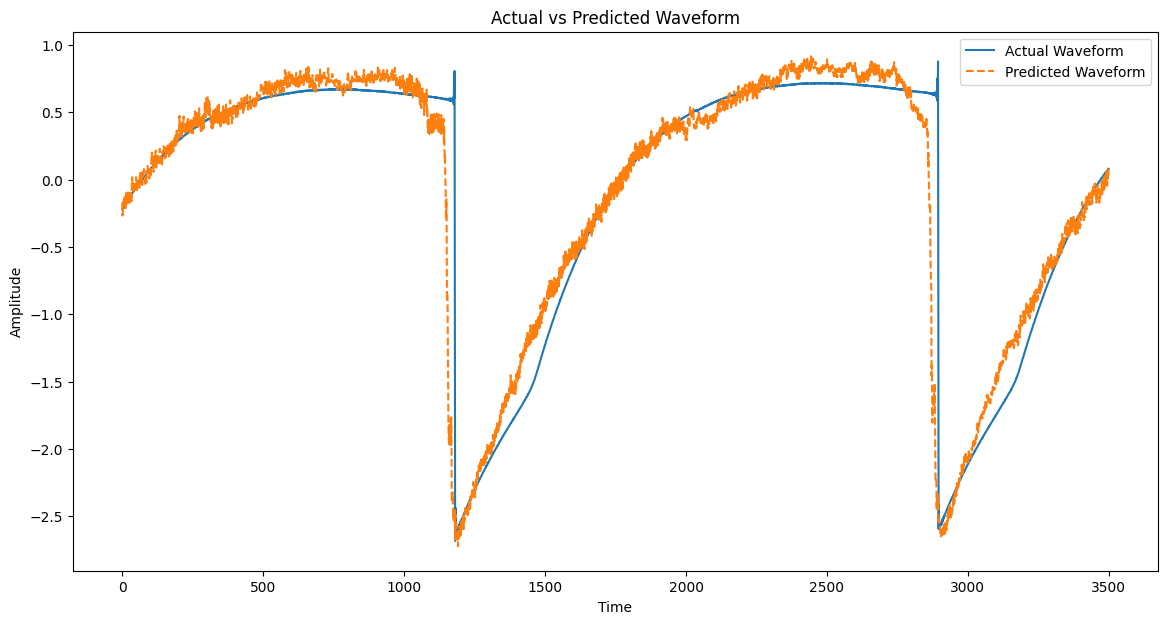

In [23]:
predictions = model.predict(X_scaled)
actual_waveform = y[1]
predicted_waveform = predictions[1]

plt.figure(figsize=(14, 7))
plt.plot(actual_waveform[2500:6000], label='Actual Waveform')
plt.plot(predicted_waveform[2500:6000], label='Predicted Waveform', linestyle='dashed')
plt.title('Actual vs Predicted Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

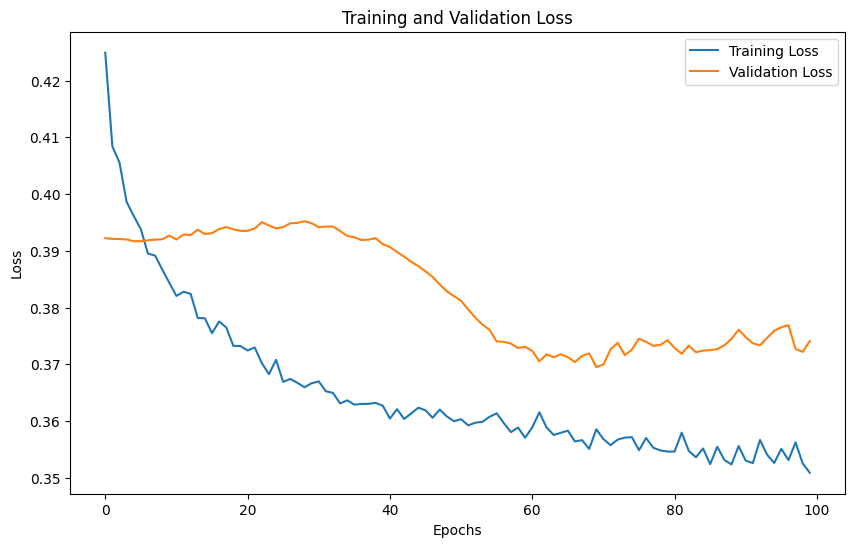

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
actual_waveform = y[1]
predicted_waveform = predictions[1]

print("Actual Audio:")
display(Audio(actual_waveform, rate=44100))

print("Predicted Audio:")
display(Audio(predicted_waveform, rate=44100))

Actual Audio:


Predicted Audio:


## LSTM Model

In [27]:
model = Sequential()
model.add(Input(shape=(X_scaled.shape[1], X_scaled.shape[2])))
model.add(LSTM(256, activation='tanh', return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(128, activation='tanh', return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(64, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1]))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=Huber())

model.summary()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001)
history = model.fit(X_scaled, y, epochs=200, batch_size=32, validation_split=0.2, callbacks=[reduce_lr])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 256)              │         268,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 128)              │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 33075)               │       2,149,875 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,670,643 (10.19 MB)

 Trainable params: 2,669,747 (10.18 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - loss: 0.4271 - val_loss: 0.3923 - learning_rate: 0.0010
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.4185 - val_loss: 0.3921 - learning_rate: 0.0010
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.4067 - val_loss: 0.3922 - learning_rate: 0.0010
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.4095 - val_loss: 0.3923 - learning_rate: 0.0010
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.4080 - val_loss: 0.3923 - learning_rate: 0.0010
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.4040 - val_loss: 0.3922 - learning_rate: 0.0010
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.4017 - val_loss: 0.3923 - learning_rate: 0.0010
Epoch 8/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.3942 - val_loss: 0.3923 - learning_rate: 0.0010
Epoch 9/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.3969 - val_loss: 0.3924 - learning_rate: 0.0010
Epoch

In [28]:
loss = model.evaluate(X_scaled, y)
print(f'Test Loss: {loss}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.3687
Test Loss: 0.3655407130718231


In [29]:
predictions = model.predict(X_scaled)

mse = mean_squared_error(y, predictions)
r2 = r2_score(y, predictions)
mae = mean_absolute_error(y, predictions)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y, predictions)
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R²): {r2}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step
Mean Absolute Percentage Error (MAPE): 2.4478431238390286
Root Mean Squared Error (RMSE): 0.9359507946732546
Mean Absolute Error (MAE): 0.7076695732140075
Mean Squared Error (MSE): 0.8760038900494969
R-squared (R²): 0.10362413714041331


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


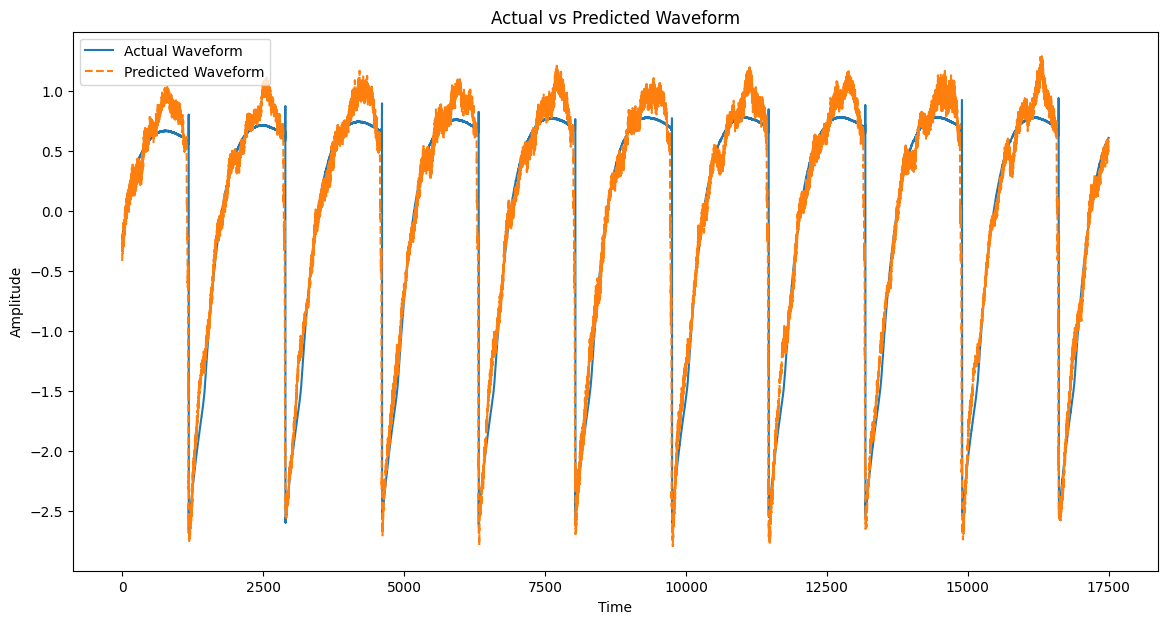

In [30]:
predictions = model.predict(X_scaled)
actual_waveform = y[1]
predicted_waveform = predictions[1]

plt.figure(figsize=(14, 7))
plt.plot(actual_waveform[2500:20000], label='Actual Waveform')
plt.plot(predicted_waveform[2500:20000], label='Predicted Waveform', linestyle='dashed')
plt.title('Actual vs Predicted Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

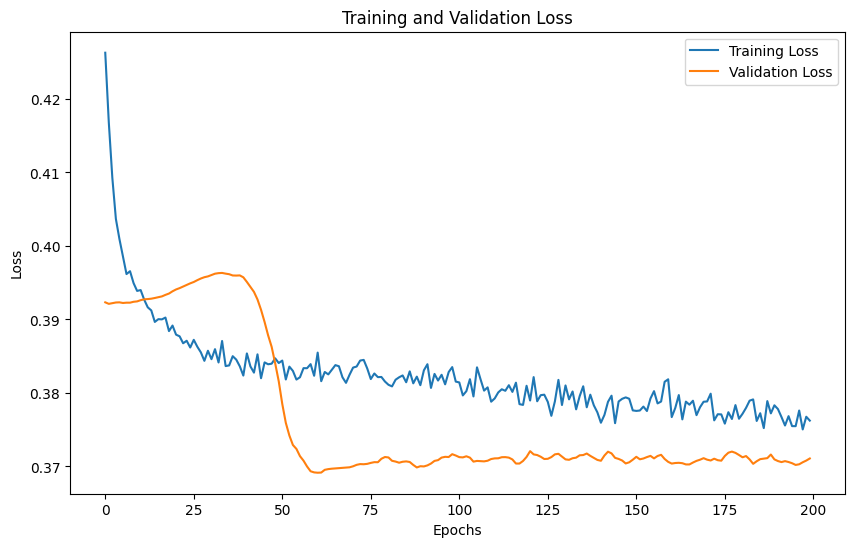

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
actual_waveform = y[1]
predicted_waveform = predictions[1]

print("Actual Audio:")
display(Audio(actual_waveform, rate=44100))

print("Predicted Audio:")
display(Audio(predicted_waveform, rate=44100))

Actual Audio:


Predicted Audio:


## Best Hyperparameters using Keras Tuner

In [34]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


In [36]:
import keras_tuner as kt

In [37]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X.shape[1], 1)))
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(GRU(units=hp.Int(f'gru_units_{i}', min_value=32, max_value=512, step=32),
                      activation='relu',
                      return_sequences=True))
        if hp.Boolean(f'batch_norm_{i}'):
            model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_rate', 0.0, 0.5, step=0.1)))
    model.add(GRU(units=hp.Int('gru_units_final', min_value=32, max_value=512, step=32),
                  activation='relu',
                  return_sequences=False))
    model.add(Dropout(hp.Float('dropout_rate_final', 0.0, 0.5, step=0.1)))
    model.add(Dense(units=hp.Int('dense_units', min_value=16, max_value=128, step=16), activation='linear'))
    model.add(Dropout(hp.Float('dropout_rate_dense', 0.0, 0.5, step=0.1)))
    model.add(Dense(y.shape[1]))

    optimizer = Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))
    model.compile(optimizer=optimizer, loss=Huber())

    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5, #number of trials, did it with 50, it took 8 hours
    executions_per_trial=2,
    directory='hyperparam_tuning',
    project_name='waveform_model'
)
tuner.search(X, y, epochs=70, batch_size=32, validation_split=0.2, callbacks=[reduce_lr])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

for param, value in best_hps.values.items():
    print(f"{param}: {value}")

model = tuner.hypermodel.build(best_hps)

model.summary()

history = model.fit(X, y, epochs=70, batch_size=32, validation_split=0.2, callbacks=[reduce_lr])
loss = model.evaluate(X, y)
print(f'Test Loss: {loss}')

Trial 5 Complete [00h 06m 13s]
val_loss: 0.3771710991859436

Best val_loss So Far: 0.36053769290447235
Total elapsed time: 00h 28m 14s
num_layers: 3
gru_units_0: 32
batch_norm_0: True
dropout_rate: 0.0
gru_units_final: 288
dropout_rate_final: 0.30000000000000004
dense_units: 112
dropout_rate_dense: 0.4
learning_rate: 0.006822989239763269
gru_units_1: 32
batch_norm_1: False
gru_units_2: 32
batch_norm_2: False


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                          │ (None, 5, 32)               │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 5, 32)               │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 5, 32)               │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_6 (GRU)                          │ (None, 5, 32)               │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 5, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_7 (GRU)                          │ (None, 288)                 │         278,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 112)                 │          32,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 112)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 33075)               │       3,737,475 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,064,211 (15.50 MB)

 Trainable params: 4,064,147 (15.50 MB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.4303 - val_loss: 0.3895 - learning_rate: 0.0068
Epoch 2/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.4200 - val_loss: 0.3924 - learning_rate: 0.0068
Epoch 3/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.4205 - val_loss: 0.3875 - learning_rate: 0.0068
Epoch 4/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 0.3945 - val_loss: 0.3889 - learning_rate: 0.0068
Epoch 5/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - loss: 0.4015 - val_loss: 0.3876 - learning_rate: 0.0068
Epoch 6/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - loss: 0.4032 - val_loss: 0.3853 - learning_rate: 0.0068
Epoch 7/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.3999 - val_loss: 0.3853 - learning_rate: 0.0068
Epoch 8/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.3914 - val_loss: 0.3866 - learning_rate: 0.0068
Epoch 9/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.4015 - val_loss: 0.3887 - learning_rate: 0.0068
Epoch 10/70


In [38]:
top_n = 2
best_hps_list = tuner.get_best_hyperparameters(num_trials=top_n)

# Print the top 10 best hyperparameters
print(f"The top {top_n} hyperparameter sets are:")
for i, hp in enumerate(best_hps_list):
    print(f"\nHyperparameters set {i + 1}:")
    for param, value in hp.values.items():
        print(f"  {param}: {value}")
    val_loss = min(history.history['val_loss'])
    print(f"  Validation Loss: {val_loss}")


best_hps = best_hps_list[0]
model = tuner.hypermodel.build(best_hps)

model.summary()

The top 2 hyperparameter sets are:

Hyperparameters set 1:
  num_layers: 3
  gru_units_0: 32
  batch_norm_0: True
  dropout_rate: 0.0
  gru_units_final: 288
  dropout_rate_final: 0.30000000000000004
  dense_units: 112
  dropout_rate_dense: 0.4
  learning_rate: 0.006822989239763269
  gru_units_1: 32
  batch_norm_1: False
  gru_units_2: 32
  batch_norm_2: False
  Validation Loss: 0.3621346354484558

Hyperparameters set 2:
  num_layers: 3
  gru_units_0: 64
  batch_norm_0: True
  dropout_rate: 0.30000000000000004
  gru_units_final: 512
  dropout_rate_final: 0.4
  dense_units: 64
  dropout_rate_dense: 0.30000000000000004
  learning_rate: 0.0006681672318520809
  gru_units_1: 256
  batch_norm_1: False
  gru_units_2: 480
  batch_norm_2: False
  Validation Loss: 0.3621346354484558


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_8 (GRU)                          │ (None, 5, 32)               │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 5, 32)               │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_9 (GRU)                          │ (None, 5, 32)               │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_10 (GRU)                         │ (None, 5, 32)               │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 5, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_11 (GRU)                         │ (None, 288)                 │         278,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 112)                 │          32,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 112)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 33075)               │       3,737,475 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,064,211 (15.50 MB)

 Trainable params: 4,064,147 (15.50 MB)

 Non-trainable params: 64 (256.00 B)

In [40]:
model = Sequential()

model.add(Input(shape=(X.shape[1], 1)))
model.add(GRU(32, activation='relu', return_sequences=True))

model.add(GRU(32, activation='relu', return_sequences=True))
model.add(GRU(32, activation='relu', return_sequences=True))

model.add(GRU(288, activation='relu', return_sequences=False))
model.add(Dropout(0.3))

model.add(Dense(112, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(y.shape[1]))

optimizer = Adam(learning_rate=0.006822989239763269)
model.compile(optimizer=optimizer, loss=Huber())

model.summary()
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001)
history = model.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, callbacks=[reduce_lr])
loss = model.evaluate(X, y)
print(f'Test Loss: {loss}')

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_12 (GRU)                         │ (None, 5, 32)               │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_13 (GRU)                         │ (None, 5, 32)               │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_14 (GRU)                         │ (None, 5, 32)               │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_15 (GRU)                         │ (None, 288)                 │         278,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 112)                 │          32,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 112)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 33075)               │       3,737,475 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,064,083 (15.50 MB)

 Trainable params: 4,064,083 (15.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - loss: 0.4203 - val_loss: 0.3902 - learning_rate: 0.0068
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.4252 - val_loss: 0.3895 - learning_rate: 0.0068
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.4222 - val_loss: 0.3891 - learning_rate: 0.0068
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.4257 - val_loss: 0.3870 - learning_rate: 0.0068
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - loss: 0.4170 - val_loss: 0.3889 - learning_rate: 0.0068
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - loss: 0.4254 - val_loss: 0.3911 - learning_rate: 0.0068
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.4171 - val_loss: 0.3905 - learning_rate: 0.0068
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.4240 - val_loss: 0.3905 - learning_rate: 0.0068
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.4252 - val_loss: 0.3897 - learning_rate: 0.0068
Epoc

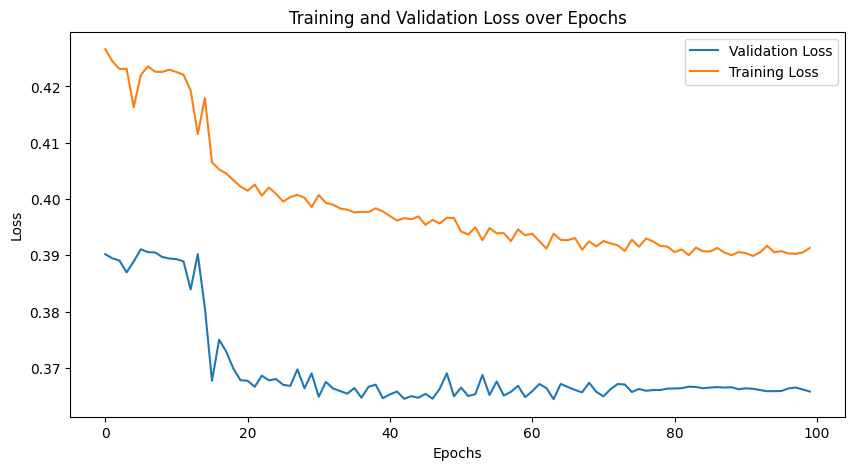

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


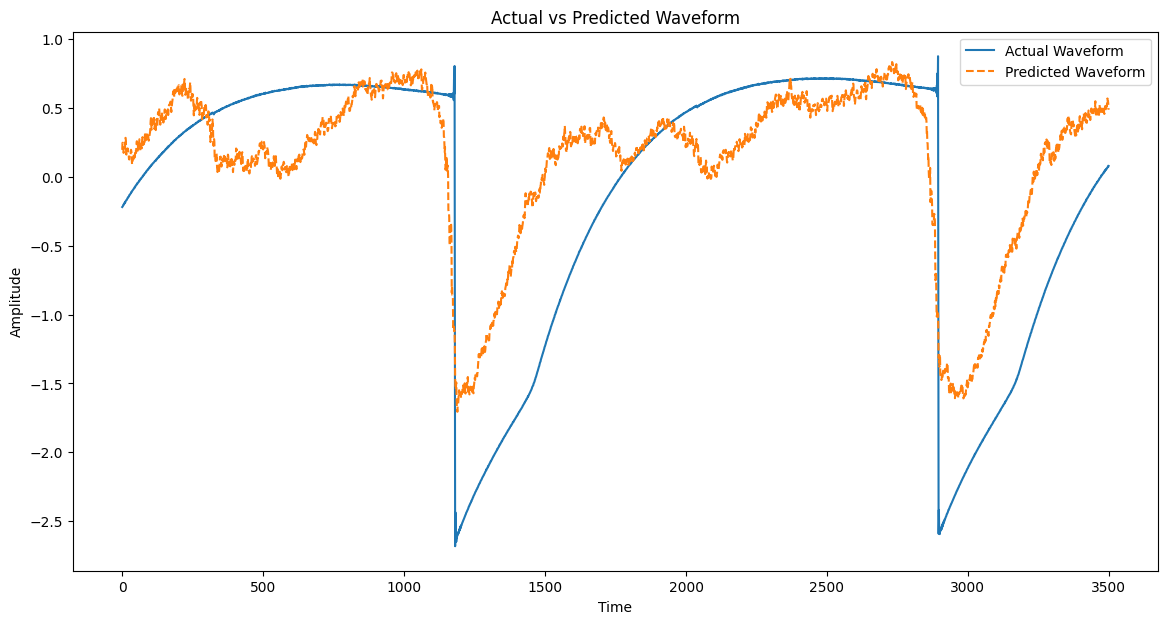

In [46]:
predictions = model.predict(X)

actual_waveform = y[1]
predicted_waveform = predictions[1]

plt.figure(figsize=(14, 7))
plt.plot(actual_waveform[2500:6000], label='Actual Waveform')
plt.plot(predicted_waveform[2500:6000], label='Predicted Waveform', linestyle='dashed')
plt.title('Actual vs Predicted Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [47]:
actual_waveform = y[1]
predicted_waveform = predictions[1]

print("Actual Audio:")
display(Audio(actual_waveform, rate=44100))

print("Predicted Audio:")
display(Audio(predicted_waveform, rate=44100))

Actual Audio:


Predicted Audio:


## Best parameters

In [48]:
# When i ran 50 tests, these were the best parametrs that came up

model = Sequential()
model.add(Input(shape=(X.shape[1], 1)))
model.add(GRU(352, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(GRU(288, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(GRU(32, activation='relu', return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(16, activation='linear'))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1]))

optimizer = Adam(learning_rate=0.0038011372648135925)
model.compile(optimizer=optimizer, loss=Huber())

model.summary()
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001)
history = model.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, callbacks=[reduce_lr])
loss = model.evaluate(X, y)
print(f'Test Loss: {loss}')

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_16 (GRU)                         │ (None, 5, 352)              │         374,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 5, 352)              │           1,408 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_17 (GRU)                         │ (None, 5, 288)              │         554,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 5, 288)              │           1,152 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 5, 288)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_18 (GRU)                         │ (None, 32)                  │          30,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 33075)               │         562,275 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,525,843 (5.82 MB)

 Trainable params: 1,524,563 (5.82 MB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 168ms/step - loss: 0.4239 - val_loss: 0.3914 - learning_rate: 0.0038
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.4159 - val_loss: 0.3898 - learning_rate: 0.0038
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 0.4084 - val_loss: 0.3894 - learning_rate: 0.0038
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 0.4079 - val_loss: 0.3905 - learning_rate: 0.0038
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - loss: 0.4009 - val_loss: 0.3917 - learning_rate: 0.0038
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 0.4093 - val_loss: 0.3971 - learning_rate: 0.0038
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - loss: 0.4022 - val_loss: 0.4030 - learning_rate: 0.0038
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 0.3989 - val_loss: 0.3971 - learning_rate: 0.0038
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.3987 - val_loss: 0.3995 - learning_rate: 0.0038


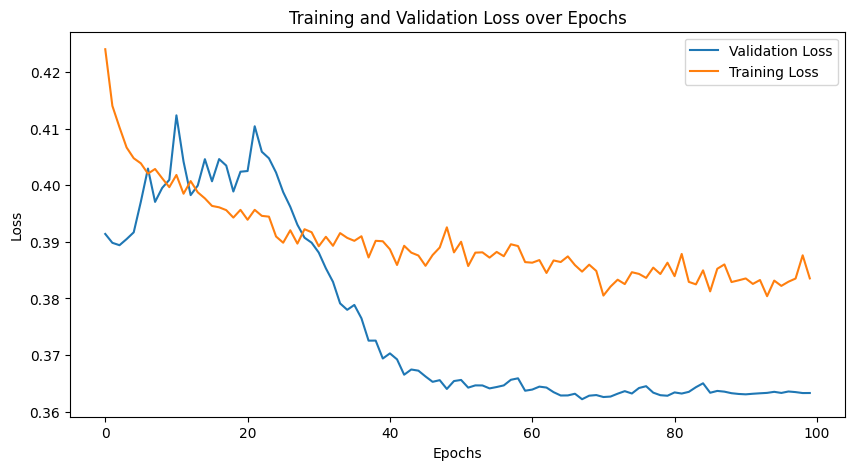

In [49]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


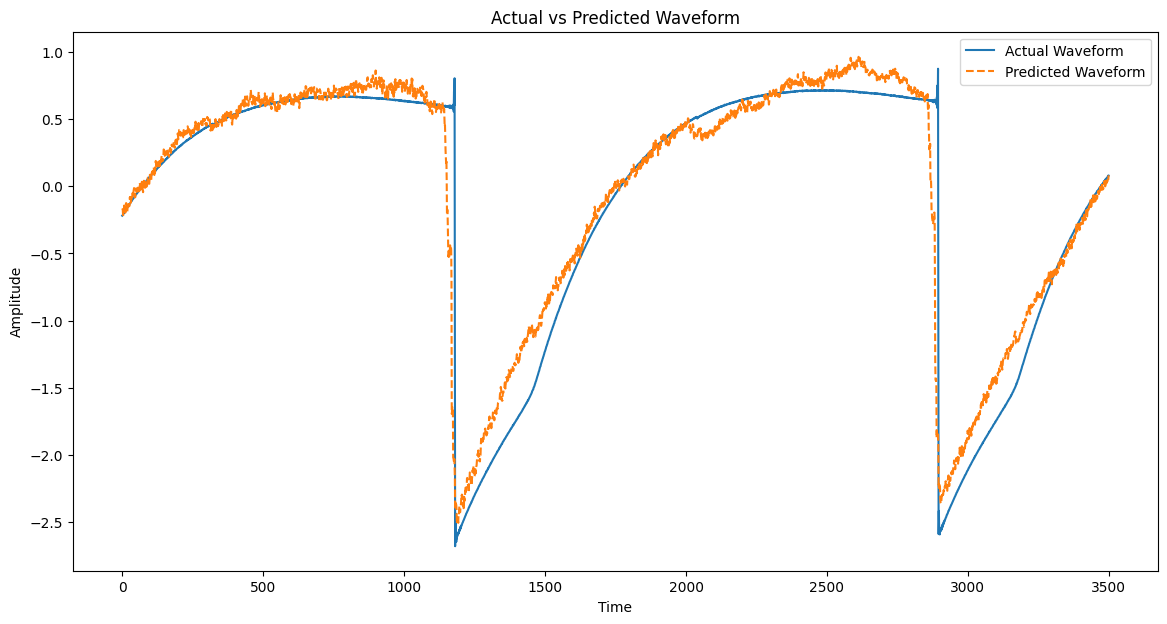

In [50]:
predictions = model.predict(X)

actual_waveform = y[1]
predicted_waveform = predictions[1]

plt.figure(figsize=(14, 7))
plt.plot(actual_waveform[2500:6000], label='Actual Waveform')
plt.plot(predicted_waveform[2500:6000], label='Predicted Waveform', linestyle='dashed')
plt.title('Actual vs Predicted Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [51]:
actual_waveform = y[1]
predicted_waveform = predictions[1]

print("Actual Audio:")
display(Audio(actual_waveform, rate=44100))

print("Predicted Audio:")
display(Audio(predicted_waveform, rate=44100))

Actual Audio:


Predicted Audio:


## Adding coorelation

In [55]:
if isinstance(df_z['waveform_data'].iloc[0], str):
    df_z['waveform_data'] = df_z['waveform_data'].apply(lambda x: x.replace('[', '').replace(']', '').strip())
    df_z['waveform_data'] = df_z['waveform_data'].apply(lambda x: np.array(list(map(float, x.split(',')))))
else:
    pass

df_z.head()

,waveform,frequency,loudness,angular_frequency,cv_frequency,cv_waveform,waveform_data
0,-1.095445,-0.570372,0.583288,-0.570372,-0.603023,-1.095445,"[0.004897026111065445, 0.007693380216497472, 0..."
1,-0.912871,-0.614286,0.116979,-0.614286,-1.658312,-0.912871,"[0.003883592364903525, 0.00569756987286506, 0...."
2,-0.912871,-0.121019,0.839874,-0.121019,0.452267,-0.912871,"[0.004425870452870818, 0.006301556181129648, 0..."
3,0.365148,0.369809,1.073398,0.369809,0.753778,0.365148,"[0.0034790566683923566, 0.0054943118451357235,..."
4,0.365148,-0.574788,1.005427,-0.574788,-1.356801,0.365148,"[-0.00030412342008344085, 0.000963275270793247..."


In [56]:
df_z['sample_index'] = np.arange(len(df_z))

In [58]:
class PhaseIntegrator:
    def __init__(self, cv: float, start_time: float = 0, end_time: float = 200, num_steps: int = 1000):
        """
        Initializes the PhaseIntegrator with the given cv value and time range.

        Args:
            cv (float): The cv value to use for the prediction.
            start_time (float, optional): Start time for the integration. Defaults to 0.
            end_time (float, optional): End time for the integration. Defaults to 200.
            num_steps (int, optional): Number of steps for integration. Defaults to 1000.
        """
        self.cv = cv
        self.start_time = start_time
        self.end_time = end_time
        self.num_steps = num_steps
        self.prediction = self.make_prediction([cv])
        self.time_steps = np.linspace(start_time, end_time, self.num_steps)
        self.first_prediction = self.prediction[0]
        if len(self.first_prediction.shape) > 0:
            self.first_prediction = np.mean(self.first_prediction)
        self.integrated_phases = np.zeros_like(self.time_steps)
        self.folded_phases = None

    def make_prediction(self, input_value):
        """
        Makes a prediction based on the input value using the model.

        Args:
            input_value (list): The input value for the prediction.

        Returns:
            np.ndarray: The predicted values.
        """
        input_value = np.array(input_value).reshape(1, -1)
        prediction = model.predict(input_value)
        return prediction

    def calculate_first_prediction(self) -> float:
        """
        Calculates the first prediction's integration result.

        Returns:
            float: The result of the integration for the first prediction.
        """
        second_time_step = self.time_steps[1]
        predicted_value = self.first_prediction
        result = second_time_step * predicted_value
        print(f'First Predicted Value: {predicted_value}')
        print(f'Result of integration: {result}')
        return result

    def integrate_phases(self) -> None:
        """
        Integrates the phases over the time steps using the first prediction.
        """
        for i, time_step in enumerate(self.time_steps):
            self.integrated_phases[i] = time_step * self.first_prediction

    def fold_phases(self) -> None:
        """
        Folds the integrated phases to be within the range [0, 1).
        """
        self.folded_phases = self.integrated_phases % 1.0

    def run(self) -> None:
        """
        Runs the full phase integration process including calculation, integration,
        folding, and plotting of phases.
        """
        self.calculate_first_prediction()
        self.integrate_phases()
        self.fold_phases()
        return self.folded_phases

In [59]:
X = df_z[['cv_frequency', 'cv_waveform', 'waveform', 'frequency', 'sample_index']]
y = np.array(df_z['waveform_data'].tolist())

folded_phases_list = []
for cv in X['cv_frequency']:
    integrator = PhaseIntegrator(cv)
    folded_phases = integrator.run()
    folded_phases_list.append(folded_phases[-1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
First Predicted Value: -0.07572793960571289
Result of integration: -0.015160748669812391
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
First Predicted Value: 0.008766954764723778
Result of integration: 0.0017551460990437994
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
First Predicted Value: -0.0836527943611145
Result of integration: -0.016747306178401304
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
First Predicted Value: -0.061184946447610855
Result of integration: -0.012249238528050222
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
First Predicted Value: -0.0116105442866683
Result of integration: -0.0023244332906242845
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
First Predicted Value: -0.083777517080307
Result of integration: -0.016772275691753154
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
First Predicted Value: -0.06030812859535217
Result of integration: -0.012073699418488924
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
First Predicted Value: 0.015114642679691315
Result of integration: 0.003025

In [60]:
X['folded_phases'] = folded_phases_list
weights = {
    'cv_frequency': 1.0,
    'cv_waveform': 1.0,
    'waveform': 1.0,
    'frequency': 4.0,
    'sample_index': 0.5,
    'folded_phases': 4.0
}

for feature in weights:
    X[feature] = X[feature] * weights[feature]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

<ipython-input-60-34ee4287e3b6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['folded_phases'] = folded_phases_list
<ipython-input-60-34ee4287e3b6>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = X[feature] * weights[feature]


In [71]:
print(f"Shape of X_scaled: {X_scaled.shape}")

model = Sequential()
model.add(Input(shape=(1, X_scaled.shape[2])))
model.add(GRU(352, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(GRU(288, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(GRU(32, activation='relu', return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(16, activation='linear'))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1]))
optimizer = Adam(learning_rate=0.0038011372648135925)
model.compile(optimizer=optimizer, loss=Huber())

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001)
history = model.fit(X_scaled, y, epochs=100, batch_size=32, validation_split=0.2, callbacks=[reduce_lr])

loss = model.evaluate(X_scaled, y)
print(f'Test Loss: {loss}')

Shape of X_scaled: (437, 1, 6)
Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - loss: 0.4238 - val_loss: 0.3916 - learning_rate: 0.0038
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.4147 - val_loss: 0.3916 - learning_rate: 0.0038
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.4103 - val_loss: 0.3913 - learning_rate: 0.0038
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.4019 - val_loss: 0.3909 - learning_rate: 0.0038
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.4069 - val_loss: 0.3909 - learning_rate: 0.0038
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.3995 - val_loss: 0.3910 - learning_rate: 0.0038
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.4149 - val_loss: 0.3904 - learning_rate: 0.0038
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.4022 - val_loss: 0.3906 - learning_rate: 0.0038
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.4023 - val_loss: 0.3912 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


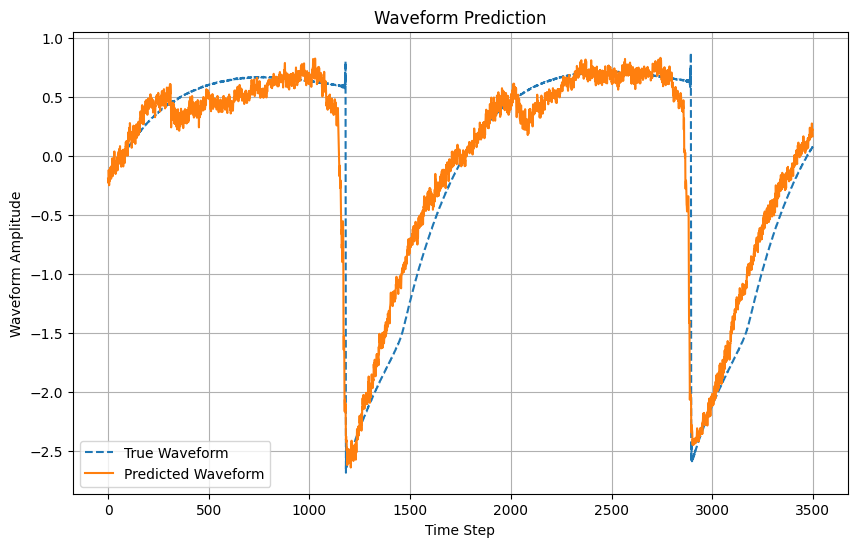

In [74]:
X= X_scaled[1]
y_true = y[1]

X = X.reshape(1, X.shape[0], X.shape[1])

y_pred = model.predict(X)

plt.figure(figsize=(10, 6))
plt.plot(y_true[2500:6000], label="True Waveform", linestyle='--')
plt.plot(y_pred[0][2500:6000], label="Predicted Waveform", linestyle='-')
plt.xlabel('Time Step')
plt.ylabel('Waveform Amplitude')
plt.title(f'Waveform Prediction')
plt.legend()
plt.grid(True)
plt.show()

In [75]:
actual_waveform = y[1]
predicted_waveform = predictions[1]

print("Actual Audio:")
display(Audio(y_true, rate=44100))

print("Predicted Audio:")
display(Audio(y_pred, rate=44100))

Actual Audio:


Predicted Audio:
